Using device: cuda
Loading graph detector model...


C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\cadem\AppData\Local\Temp\ipykernel_16960\556416787.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary 

Graph detector loaded successfully
Loading hearing loss classifier model...


C:\Users\cadem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\cadem\AppData\Local\Temp\ipykernel_16960\556416787.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`.

Hearing loss classifier loaded successfully
Analyzing audiogram: C:\Users\cadem\OneDrive\Documents\COLLEGE\SENIOR\Spring 2025\Deep Learning in AI\Project\Code\Left_Ear_Charts\T155 Left.jpg
Step 1: Detecting graph and table regions...
No graph region detected, using full image
Step 2: Analyzing audiogram grid...
Grid analysis completed successfully
Step 3: Running hearing loss classifier...
Classifier result: Conductive Hearing Loss

--- Audiogram Analysis Results ---
Hearing Loss Type: Conductive Hearing Loss

Confidence Scores:
  - No Hearing Loss: 0.03%
  - Conductive Hearing Loss: 99.92%
  - Sensorineural Hearing Loss: 0.05%
Saved visualization to T155 Left_analysis.png


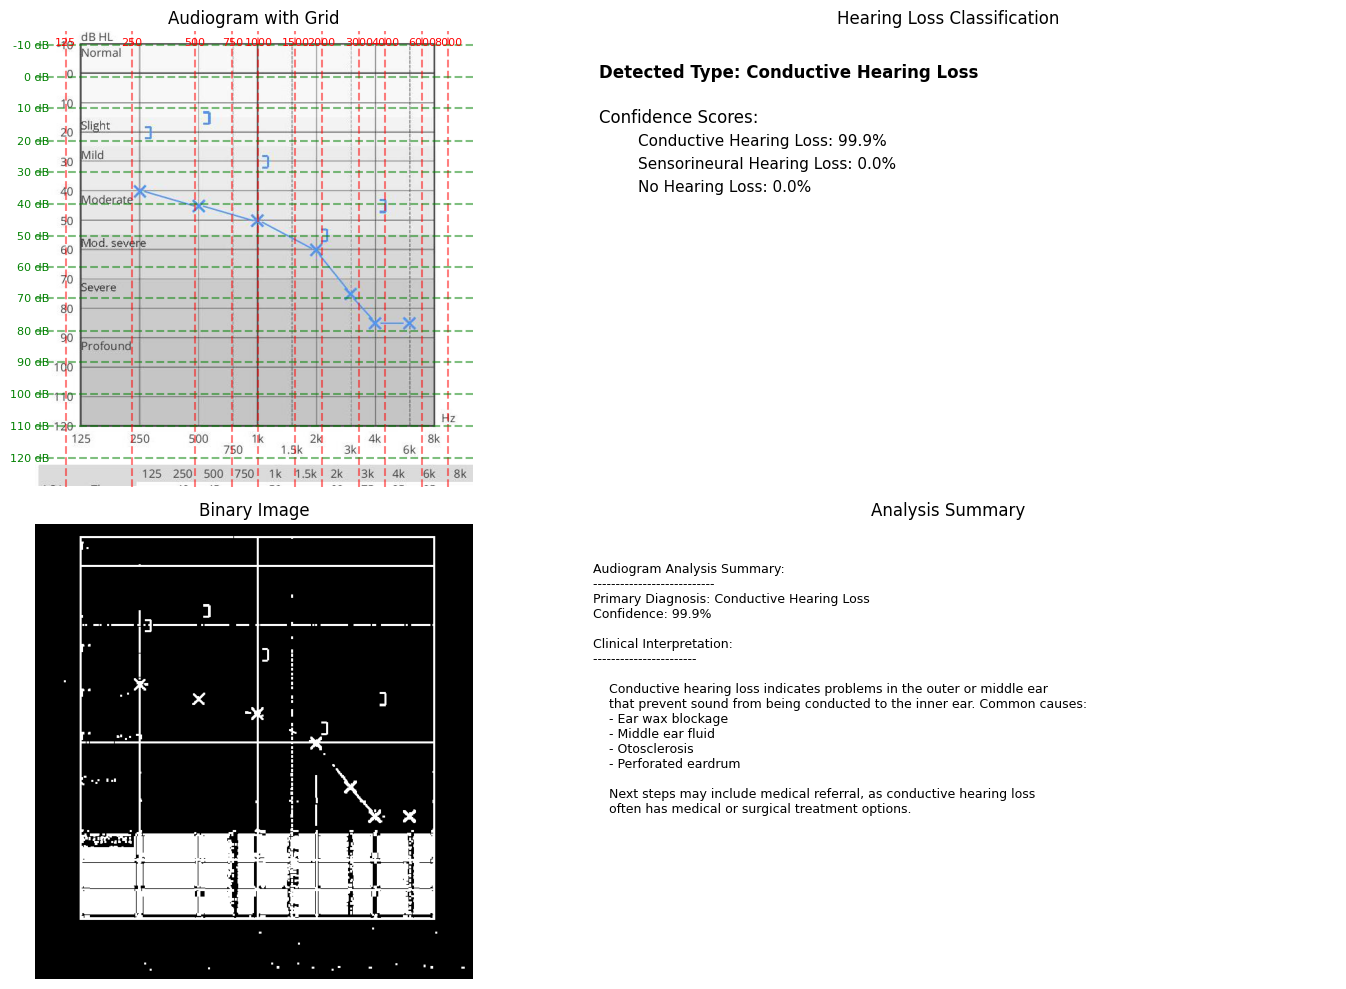

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# AudiogramGridProcessor for grid detection and alignment
class AudiogramGridProcessor:
    def __init__(self):
        self.frequencies = [125, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 6000, 8000]
        self.db_levels = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
        self.categories = ["Profound", "Severe", "Mod. Severe", "Moderate", "Mild", "Slight", "Normal"]
        self.x_grid_normalized = [0.07, 0.22, 0.364, 0.45, 0.51, 0.595, 0.655, 0.74, 0.80, 0.885, 0.945]
        self.y_grid_normalized = [0.03, 0.10, 0.17, 0.24, 0.31, 0.38, 0.45, 0.517, 0.587, 0.657, 0.727, 0.797, 0.867, 0.937]

    def preprocess_image(self, image_path):
        """Preprocess the audiogram image for analysis without OpenCV"""
        image = Image.open(image_path).convert('RGB')
        gray = ImageOps.grayscale(image)

        # Thresholding
        threshold = 200
        binary = gray.point(lambda p: 255 if p < threshold else 0)

        # Morphological operations (basic smoothing using filter)
        binary = binary.filter(ImageFilter.MinFilter(3)).filter(ImageFilter.MaxFilter(3))

        binary_np = np.array(binary)
        return np.array(image), binary_np

    def align_image_to_grid(self, image, binary):
        height, width = binary.shape
        x_grid_pixels = [int(x * width) for x in self.x_grid_normalized]
        y_grid_pixels = [int(y * height) for y in self.y_grid_normalized]
        return image, x_grid_pixels, y_grid_pixels

    def extract_grid_coordinates(self, image_path):
        image, binary = self.preprocess_image(image_path)
        aligned_image, x_grid, y_grid = self.align_image_to_grid(image, binary)

        freq_mapping = dict(zip(x_grid, self.frequencies))
        db_mapping = dict(zip(y_grid, self.db_levels))

        return {
            'image': aligned_image,
            'binary': binary,
            'x_grid': x_grid,
            'y_grid': y_grid,
            'freq_mapping': freq_mapping,
            'db_mapping': db_mapping
        }

    def visualize_grid(self, image_path):
        result = self.extract_grid_coordinates(image_path)
        image_rgb = result['image']

        plt.figure(figsize=(12, 8))
        plt.imshow(image_rgb)

        for x in result['x_grid']:
            plt.axvline(x=x, color='r', linestyle='--', alpha=0.5)
            freq = result['freq_mapping'][x]
            plt.text(x, 20, f"{freq}", color='red', fontsize=8, ha='center')

        for y in result['y_grid']:
            plt.axhline(y=y, color='g', linestyle='--', alpha=0.5)
            db = result['db_mapping'][y]
            plt.text(20, y, f"{db} dB", color='green', fontsize=8, va='center', ha='right')

        plt.title('Audiogram Grid Detection')
        plt.tight_layout()
        plt.axis('off')
        plt.show()
        
        return result

# Graph and Table detection dataset
class AudiogramDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.imgs = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        # For training, providing bounding box annotations
        img_path = self.imgs[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Example annotation format - you'll need to replace with actual annotations
        # Each audiogram would have bbox coordinates for graph and table
        # Format: [x_min, y_min, x_max, y_max, class_label]
        boxes = torch.tensor([[50, 50, 300, 400, 0], [350, 50, 500, 200, 1]], dtype=torch.float32)
        
        target = {}
        target["boxes"] = boxes[:, :4]
        target["labels"] = boxes[:, 4].long()
        
        if self.transform:
            image = self.transform(image)
            
        return image, target

# Hearing Loss Classification Dataset
class HearingLossDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # Define the classes based on your directory structure
        self.classes = ['No Hearing Loss', 'Conductive Hearing Loss', 'Sensorineural Hearing Loss']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        print(f"Looking for images in: {root_dir}")
        
        # Map folder names to class names
        folder_to_class = {
            'no_hearing_loss_train': 'No Hearing Loss',
            'conductive_hearing_loss_train': 'Conductive Hearing Loss', 
            'sensorineural_hearing_loss_train': 'Sensorineural Hearing Loss'
        }
        
        # Scan through the training directories directly
        for folder_name, class_name in folder_to_class.items():
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.exists(folder_path) and os.path.isdir(folder_path):
                print(f"Scanning directory: {folder_path}")
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    if os.path.isfile(img_path) and img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        class_idx = self.class_to_idx[class_name]
                        self.samples.append((img_path, class_idx))
                        print(f"Added image: {img_path} as {class_name}")
            else:
                print(f"Warning: Directory {folder_path} not found")
        
        print(f"Total samples found: {len(self.samples)}")
        if len(self.samples) == 0:
            raise ValueError(f"No valid image files found in the directories under {root_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            # Return a placeholder in case of error
            if self.transform:
                return torch.zeros((3, 224, 224)), label
            else:
                return Image.new('RGB', (224, 224)), label

# Hearing Loss Classifier - Using ResNet as backbone
class HearingLossClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HearingLossClassifier, self).__init__()
        self.backbone = torchvision.models.resnet50(pretrained=True)
        
        # Freeze earlier layers
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
            
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Main class for Audiogram Analysis
class AudiogramAnalyzer:
    def __init__(self, 
                 graph_detector_path="audiogram_graph_detector.pth",
                 hearing_loss_classifier_path="hearing_loss_classifier.pth"):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Load Graph and Table Detector
        print("Loading graph detector model...")
        self.graph_detector = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=3)
        if os.path.exists(graph_detector_path):
            self.graph_detector.load_state_dict(torch.load(graph_detector_path, map_location=self.device))
            self.graph_detector.to(self.device)
            self.graph_detector.eval()
            print("Graph detector loaded successfully")
        else:
            print(f"Warning: Graph detector model not found at {graph_detector_path}")
            print("Graph and table detection will be skipped")
            self.graph_detector = None
        
        # Initialize the Grid Processor
        self.grid_processor = AudiogramGridProcessor()
        
        # Load Hearing Loss Classifier
        print("Loading hearing loss classifier model...")
        self.hearing_loss_classifier = HearingLossClassifier(num_classes=3)  # normal, conductive, sensorineural
        if os.path.exists(hearing_loss_classifier_path):
            self.hearing_loss_classifier.load_state_dict(torch.load(hearing_loss_classifier_path, map_location=self.device))
            self.hearing_loss_classifier.to(self.device)
            self.hearing_loss_classifier.eval()
            print("Hearing loss classifier loaded successfully")
        else:
            print(f"Warning: Hearing loss classifier model not found at {hearing_loss_classifier_path}")
            print("Hearing loss classification will be skipped")
            self.hearing_loss_classifier = None
        
        # Define transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        self.hearing_loss_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Define class labels
        self.hearing_loss_classes = ['No Hearing Loss', 'Conductive Hearing Loss', 'Sensorineural Hearing Loss']
        
    def preprocess_image(self, image_path):
        """Load and preprocess the audiogram image"""
        try:
            image = Image.open(image_path).convert("RGB")
            return image
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None
    
    def detect_graph_and_table(self, image):
        """Detect audiogram graph and table regions"""
        if self.graph_detector is None:
            print("Graph detector not loaded, using full image")
            return image, None
        
        with torch.no_grad():
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            predictions = self.graph_detector(img_tensor)
            
        boxes = predictions[0]['boxes'].cpu().numpy().astype(np.int32)
        scores = predictions[0]['scores'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()
        
        # Filter detections by confidence threshold
        confident_detections = scores > 0.5
        
        graph_region = None
        table_region = None
        
        # Find the graph and table regions
        for box, label, score in zip(boxes[confident_detections], 
                                     labels[confident_detections], 
                                     scores[confident_detections]):
            if label == 1:  # Graph label
                print(f"Found graph region with confidence {score:.2f}")
                x1, y1, x2, y2 = max(0, box[0]), max(0, box[1]), min(image.width, box[2]), min(image.height, box[3])
                graph_region = image.crop((x1, y1, x2, y2))
            elif label == 2:  # Table label
                print(f"Found table region with confidence {score:.2f}")
                x1, y1, x2, y2 = max(0, box[0]), max(0, box[1]), min(image.width, box[2]), min(image.height, box[3])
                table_region = image.crop((x1, y1, x2, y2))
        
        if graph_region is None:
            print("No graph region detected, using full image")
            graph_region = image
            
        return graph_region, table_region
    
    def analyze_grid(self, image_path):
        """Analyze the audiogram grid using the AudiogramGridProcessor"""
        try:
            grid_results = self.grid_processor.extract_grid_coordinates(image_path)
            print("Grid analysis completed successfully")
            return grid_results
        except Exception as e:
            print(f"Error analyzing grid: {e}")
            return None
    
    def analyze_hearing_loss(self, image):
        """Classify the type of hearing loss"""
        if self.hearing_loss_classifier is None:
            print("Hearing loss classifier not loaded, skipping classification")
            return "Unknown", {}
        
        with torch.no_grad():
            # Preprocess the image for the hearing loss classifier
            img_tensor = self.hearing_loss_transform(image).unsqueeze(0).to(self.device)
            
            # Get the classifier prediction
            outputs = self.hearing_loss_classifier(img_tensor)
            _, predicted = torch.max(outputs, 1)
            
            predicted_class = self.hearing_loss_classes[predicted.item()]
            
            # Get confidence scores for all classes
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()
            
            class_probabilities = {cls: float(prob) for cls, prob in zip(self.hearing_loss_classes, probabilities)}
            
        return predicted_class, class_probabilities
    
    def analyze_audiogram(self, image_path):
        """Complete audiogram analysis pipeline"""
        print(f"Analyzing audiogram: {image_path}")
        
        # Load and preprocess the image
        original_image = self.preprocess_image(image_path)
        if original_image is None:
            return {"error": "Failed to load image"}
        
        # Step 1: Detect graph and table regions
        print("Step 1: Detecting graph and table regions...")
        graph_region, table_region = self.detect_graph_and_table(original_image)
        
        # Step 2: Analyze the audiogram grid
        print("Step 2: Analyzing audiogram grid...")
        grid_analysis = self.analyze_grid(image_path)
        
        # Step 3: Analyze hearing loss type using the classifier
        print("Step 3: Running hearing loss classifier...")
        hearing_loss_type, probabilities = self.analyze_hearing_loss(original_image)
        print(f"Classifier result: {hearing_loss_type}")
        
        # Create analysis report
        report = {
            "hearing_loss_type": hearing_loss_type,
            "confidence_scores": probabilities,
            "grid_analysis": grid_analysis
        }
        
        return report
    
    def visualize_results(self, image_path, report):
        """Visualize the audiogram analysis results"""
        image = Image.open(image_path)
        image_array = np.array(image)

        plt.figure(figsize=(15, 10))
        
        # Display original image with grid
        plt.subplot(2, 2, 1)
        plt.imshow(image_array)
        
        # Add grid lines if available
        if report.get('grid_analysis'):
            grid_data = report['grid_analysis']
            for x in grid_data['x_grid']:
                plt.axvline(x=x, color='r', linestyle='--', alpha=0.5)
                freq = grid_data['freq_mapping'][x]
                plt.text(x, 20, f"{freq}", color='red', fontsize=8, ha='center')

            for y in grid_data['y_grid']:
                plt.axhline(y=y, color='g', linestyle='--', alpha=0.5)
                db = grid_data['db_mapping'][y]
                plt.text(20, y, f"{db} dB", color='green', fontsize=8, va='center', ha='right')
        
        plt.title("Audiogram with Grid")
        plt.axis("off")
        
        # Display hearing loss classification results
        plt.subplot(2, 2, 2)
        plt.axis("off")
        plt.title("Hearing Loss Classification")
        
        # Display classification results
        y_pos = 0.9
        plt.text(0.05, y_pos, f"Detected Type: {report['hearing_loss_type']}", fontsize=12, fontweight='bold')
        y_pos -= 0.1
        
        plt.text(0.05, y_pos, "Confidence Scores:", fontsize=12)
        y_pos -= 0.05
        
        # Sort classes by confidence
        sorted_classes = sorted(report['confidence_scores'].items(), key=lambda x: x[1], reverse=True)
        for cls, prob in sorted_classes:
            plt.text(0.1, y_pos, f"{cls}: {prob:.1%}", fontsize=11)
            y_pos -= 0.05
        
        # Display binary image if available
        if report.get('grid_analysis') and 'binary' in report['grid_analysis']:
            plt.subplot(2, 2, 3)
            plt.imshow(report['grid_analysis']['binary'], cmap='gray')
            plt.title("Binary Image")
            plt.axis("off")
        
        # Display a summary
        plt.subplot(2, 2, 4)
        plt.axis("off")
        plt.title("Analysis Summary")
        
        summary_text = f"""
        Audiogram Analysis Summary:
        ---------------------------
        Primary Diagnosis: {report['hearing_loss_type']}
        Confidence: {report['confidence_scores'].get(report['hearing_loss_type'], 0):.1%}
        
        Clinical Interpretation:
        -----------------------
        """
        
        # Add some clinical interpretation based on the hearing loss type
        if "Conductive" in report['hearing_loss_type']:
            summary_text += """
            Conductive hearing loss indicates problems in the outer or middle ear
            that prevent sound from being conducted to the inner ear. Common causes:
            - Ear wax blockage
            - Middle ear fluid
            - Otosclerosis
            - Perforated eardrum
            
            Next steps may include medical referral, as conductive hearing loss
            often has medical or surgical treatment options.
            """
        elif "Sensorineural" in report['hearing_loss_type']:
            summary_text += """
            Sensorineural hearing loss indicates damage to the inner ear (cochlea)
            or the nerve pathways from the inner ear to the brain. Common causes:
            - Age-related hearing loss (presbycusis)
            - Noise exposure
            - Certain medications
            - Inner ear disorders
            
            Next steps typically include hearing aid evaluation or other
            amplification options.
            """
        else:
            summary_text += """
            The audiogram results require further evaluation to determine
            appropriate intervention strategies.
            """
        
        plt.text(0, 0.95, summary_text, fontsize=9, va='top', ha='left', wrap=True)
        
        plt.tight_layout()
        
        # Save the visualization
        output_filename = os.path.splitext(os.path.basename(image_path))[0] + "_analysis.png"
        plt.savefig(output_filename)
        print(f"Saved visualization to {output_filename}")
        
        # Show the plot
        plt.show()
        
        return output_filename

# Training functions for the models
def train_graph_detector(data_dir, output_path="audiogram_graph_detector.pth", num_epochs=10):
    """Train the graph and table detector"""
    # Data transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Create the dataset
    dataset = AudiogramDataset(
        img_dir=data_dir,
        transform=transform
    )

    # Create data loader
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    # Load a pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Modify the model for our specific classes (background, graph, table)
    num_classes = 3
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Training setup
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        i = 0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            i += 1
            if i % 10 == 0:
                print(f"Epoch: {epoch}, Batch: {i}, Loss: {losses.item()}")

    # Save the model
    torch.save(model.state_dict(), output_path)
    print(f"Model saved to {output_path}")
    return model

def train_hearing_loss_classifier(data_dir, output_path="hearing_loss_classifier.pth", num_epochs=15):
    """Train the hearing loss classifier"""
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create dataset
    try:
        dataset = HearingLossDataset(root_dir=data_dir, transform=transform)
        print(f"Successfully created dataset with {len(dataset)} samples")
        data_loader = DataLoader(dataset, batch_size=min(16, len(dataset)), shuffle=True)
    except Exception as e:
        print(f"Error creating dataset: {str(e)}")
        return None

    # Set up the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = HearingLossClassifier(num_classes=len(dataset.classes))
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(data_loader)}, Accuracy: {100 * correct / total}%")

    # Save the model
    torch.save(model.state_dict(), output_path)
    print(f"Model saved to {output_path}")
    return model

# Example usage
def analyze_audiogram_sample(audiogram_path):
    analyzer = AudiogramAnalyzer(
        graph_detector_path="audiogram_graph_detector.pth",
        hearing_loss_classifier_path="hearing_loss_classifier.pth"
    )
    
    # Analyze the audiogram
    report = analyzer.analyze_audiogram(audiogram_path)
    
    # Print results
    print("\n--- Audiogram Analysis Results ---")
    print(f"Hearing Loss Type: {report['hearing_loss_type']}")
    print("\nConfidence Scores:")
    for cls, prob in report['confidence_scores'].items():
        print(f"  - {cls}: {prob:.2%}")
    
    # Visualize results
    analyzer.visualize_results(audiogram_path, report)
    
    return report

# Use this function to analyze a single audiogram
if __name__ == "__main__":
    # Training - uncomment to train models
    # train_graph_detector('graph_and_table_detection_train')
    # train_hearing_loss_classifier('hearing_loss_classification_train')
    
    # Analysis
    test_audiogram = "C:\\Users\\cadem\\OneDrive\\Documents\\COLLEGE\\SENIOR\\Spring 2025\\Deep Learning in AI\\Project\\Code\\Left_Ear_Charts\\T155 Left.jpg"
    analyze_audiogram_sample(test_audiogram)

Looking for images in: hearing_loss_classification_train
Scanning directory: hearing_loss_classification_train\no_hearing_loss_train
Added image: hearing_loss_classification_train\no_hearing_loss_train\N1 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N11 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N120 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N136 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N137 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N14 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N15 Left.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_hearing_loss_train\N170 Right.jpg as No Hearing Loss
Added image: hearing_loss_classification_train\no_he

C:\Users\cadem\AppData\Local\Temp\ipykernel_16960\556416787.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.graph_detector.load_state_dict(torch.load(graph_detect

Graph detector loaded successfully
Loading hearing loss classifier model...


C:\Users\cadem\AppData\Local\Temp\ipykernel_16960\556416787.py:221: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hearing_loss_classifier.load_state_dict(torch.load(hea

Hearing loss classifier loaded successfully
Analyzing audiogram: C:\Users\cadem\OneDrive\Documents\COLLEGE\SENIOR\Spring 2025\Deep Learning in AI\Project\Code\Left_Ear_Charts\T155 Left.jpg
Step 1: Detecting graph and table regions...
No graph region detected, using full image
Step 2: Analyzing audiogram grid...
Grid analysis completed successfully
Step 3: Running hearing loss classifier...
Classifier result: Conductive Hearing Loss

--- Audiogram Analysis Results ---
Hearing Loss Type: Conductive Hearing Loss

Confidence Scores:
  - No Hearing Loss: 0.06%
  - Conductive Hearing Loss: 99.85%
  - Sensorineural Hearing Loss: 0.09%
Saved visualization to T155 Left_analysis.png


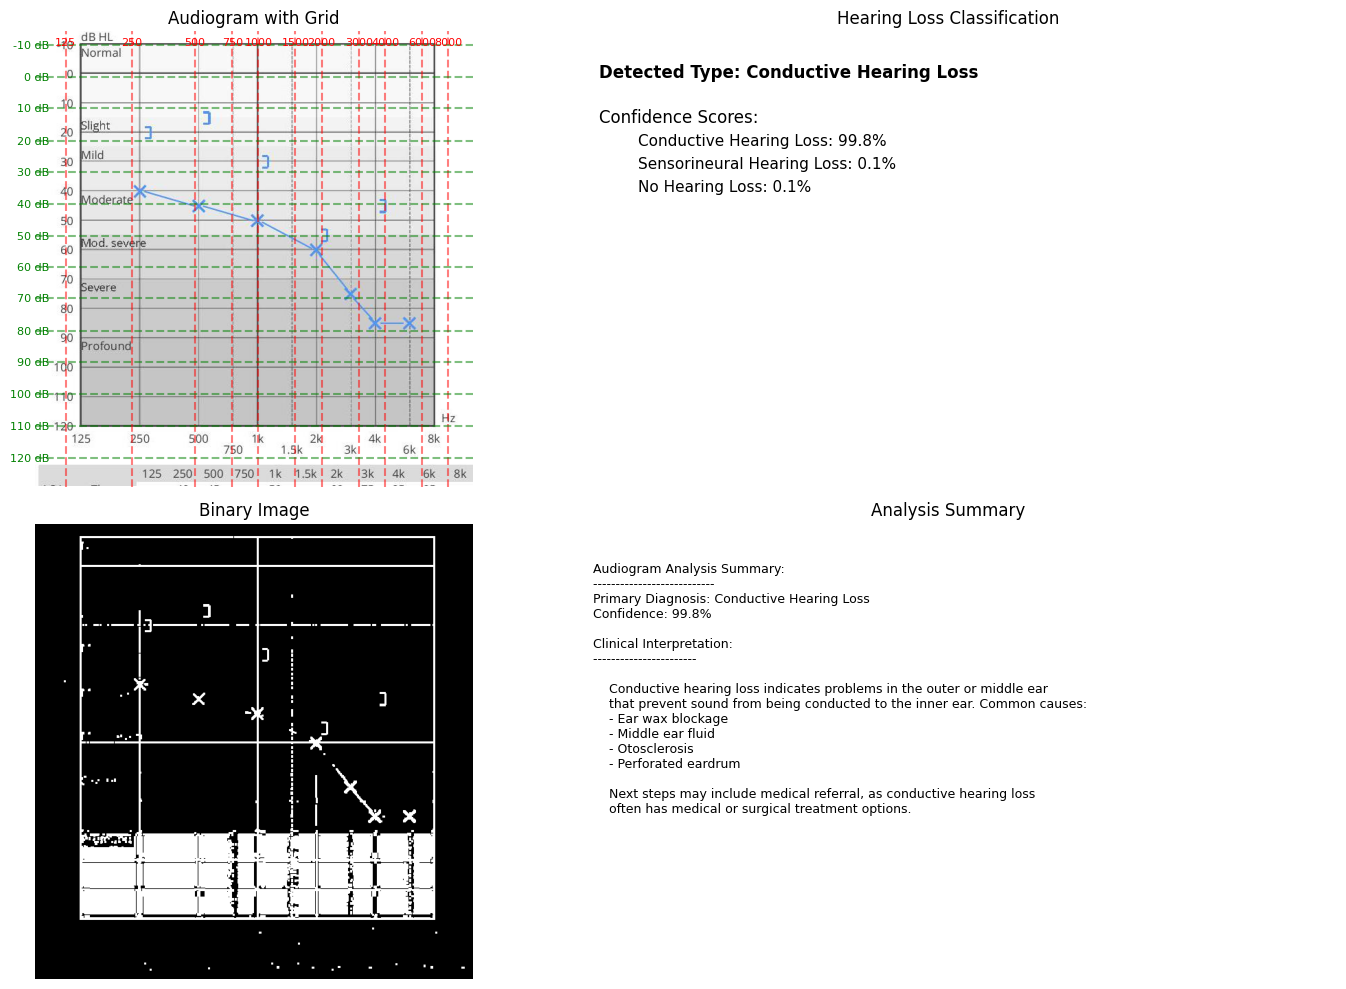

In [4]:
# Use this function to analyze a single audiogram
if __name__ == "__main__":
    # Training - uncomment to train models
    #train_graph_detector('graph_and_table_detection_train')
    train_hearing_loss_classifier('hearing_loss_classification_train')
    
    # Analysis
    test_audiogram = "C:\\Users\\cadem\\OneDrive\\Documents\\COLLEGE\\SENIOR\\Spring 2025\\Deep Learning in AI\\Project\\Code\\Left_Ear_Charts\\T155 Left.jpg"
    analyze_audiogram_sample(test_audiogram)